### 从本地读取数据

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from collections import Counter
import tensorflow as tf


import os
import pickle
import re
from tensorflow.python.ops import math_ops

C:\Users\zhangy\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
UserID_map_max_len, ItemID_map_max_len, User_Cluster_map_max_len, \
User_CateIDs_map_max_len, User_BrandIDs_map_max_len, \
CategoryID_map_max_len, ShopID_map_max_len, BrandID_map_max_len, Com_CateID_map_max_len,\
Com_ShopID_map_max_len, Com_BrandID_map_max_len, PID_map_max_len, UserID2int, ItemID2int,\
User_Cluster2int, User_CateIDs2int, User_BrandIDs2int,  CategoryID2int, ShopID2int, BrandID2int, Com_CateID2int, \
Com_ShopID2int, Com_BrandID2int, PID2int, train_features, train_targets_values, train_data, \
test_features, test_targets_values, test_data = pickle.load(open('C:/Users/zhangy/Desktop/ctr_cvr_data/preprocess.p', mode='rb'))
print(0)

0


### Embedding Lookup 示例

In [9]:
c = np.random.random([10,1])
b = tf.nn.embedding_lookup(c, [1])
a = tf.nn.embedding_lookup(c,1)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print("b:",sess.run(b))
    print("a:",sess.run(a))
    print("c:",c)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
b: [[0.33532542]]
a: [0.33532542]
c: [[8.86178338e-01]
 [3.35325420e-01]
 [6.44403739e-01]
 [4.93211984e-01]
 [2.14610187e-01]
 [2.62395490e-01]
 [2.06911872e-04]
 [8.39682121e-01]
 [4.06417898e-01]
 [1.38421449e-01]]


### Tensorflow slice 示例

In [10]:
#创建常量
t = tf.constant([[1,100],[2,99],[3,98]])

In [11]:
print(t)

Tensor("Const:0", shape=(3, 2), dtype=int32)


In [17]:
#tf.slice()使用方法：https://www.jianshu.com/p/71e6ef6c121b
t1 = tf.slice(t,[0,1],[-1,1])
t2 = 1 - t1
t3 = tf.concat([t1,t2],axis=1)
with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    print("t1:",sess.run(t1))
    print("t2:",sess.run(t2))
    print("t3:",sess.run(t3))

t1: [[100]
 [ 99]
 [ 98]]
t2: [[-99]
 [-98]
 [-97]]
t3: [[100 -99]
 [ 99 -98]
 [ 98 -97]]


### 训练测试集Split 示例

In [23]:
## 计算AUC
X,y = np.arange(10).reshape(5,2),range(5)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state=42)
print(X)
print(y)
print(X_test)
print(y_test)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
range(0, 5)
[[2 3]
 [8 9]]
[1, 4]


### AUC计算

In [65]:
# 整个Batch AUC计算，适合CTR、CTCVR

def calc_auc(raw_arr):
    #sort by pred value,from small to big
    arr = sorted(raw_arr,key=lambda d:d[2])
    
    auc = 0.0
    fp1, tp1, fp2, tp2 = 0.0, 0.0, 0.0, 0.0
    for record in arr:
        fp2 += record[0]#no click
        tp2 += record[1]#click
        auc += (fp2 - fp1)*(tp2 + tp1)
        fp1,tp1 = fp2,tp2
        
        
    #if all noclick or click,disgard
    threshold = len(arr) - 1e-3
    if tp2 > threshold or fp2 > threshold:
        return -0.5
    if tp2 * fp2 > 0.0:#normal auc
        return (1.0-auc/(2.0 * tp2*fp2))
    else:
        return None
    
# AUC 带Filter计算（CVR AUC只需要计算Click=1的样本子集）
def calc_auc_with_filter(raw_arr,filter_arr):
    #get filter array row indexes
    filter_index = np.nonzero(filter_arr)[0].tolist()
    input_arr = [raw_arr[index] for index in filter_index]
    auc_val = calc_auc(input_arr)
    return auc_val

## 构建神经网络

### 定义输入
定义输入的占位符

In [66]:
def get_inputs():
    UserID = tf.placeholder(tf.int32,[None,1],name="UserID")
    ItemID = tf.placeholder(tf.int32,[None,1],name="ItemID")
    User_Cluster = tf.placeholder(tf.int32, [None, 1], name="User_Cluster")
    User_CateIDs = tf.placeholder(tf.int32, [None, 100], name="User_CateIDs")
    User_BrandIDs = tf.placeholder(tf.int32, [None, 100], name="User_BrandIDs")
    
    CategoryID = tf.placeholder(tf.int32, [None, 1], name="CategoryID")
    ShopID = tf.placeholder(tf.int32, [None, 1], name="ShopID")
    BrandID = tf.placeholder(tf.int32, [None, 1], name="BrandID")
    Com_CateID = tf.placeholder(tf.int32, [None, 1], name="Com_CateID")
    Com_ShopID = tf.placeholder(tf.int32, [None, 1], name="Com_ShopID")
    Com_BrandID = tf.placeholder(tf.int32, [None, 1], name="Com_BrandID")
    PID = tf.placeholder(tf.int32, [None, 1], name="PID")
    
    targets = tf.placeholder(tf.float32, [None, 2], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    return  UserID, ItemID, User_Cluster, CategoryID, ShopID, BrandID, Com_CateID,\
            Com_ShopID, Com_BrandID, PID, User_CateIDs, User_BrandIDs, targets, LearningRate

### 特征MaxID计算
方便Embedding初始化

In [67]:
#嵌入矩阵的维度
embed_dim = 12
#userID个数
UserID_max = max(UserID2int.values()) + 1
ItemID_max = max(ItemID2int.values()) + 1
User_Cluster_max = max(User_Cluster2int.values()) + 1
User_CateIDs_max = max(User_CateIDs2int.values()) + 1 
User_BrandIDs_max = max(User_BrandIDs2int.values()) + 1 

CategoryID_max = max(CategoryID2int.values()) + 1 
ShopID_max = max(ShopID2int.values()) + 1 
BrandID_max = max(BrandID2int.values()) + 1 
Com_CateID_max = max(Com_CateID2int.values()) + 1 
Com_ShopID_max = max(Com_ShopID2int.values()) + 1 
Com_BrandID_max = max(Com_BrandID2int.values()) + 1 
PID_max = max(PID2int.values()) + 1 

#边长特征pooling方式
combiner = "sum"

print(UserID_max,ItemID_max, User_Cluster_max, User_CateIDs_max, User_BrandIDs_max, CategoryID_max, ShopID_max, BrandID_max, \
      Com_CateID_max, Com_ShopID_max, Com_BrandID_max, PID_max)

317895 686710 98 12127 368194 6836 281268 109393 5808 125291 56197 3


### 对所有输入做Embedding

In [68]:
def define_embedding_layers(UserID, ItemID, User_Cluster, CategoryID, ShopID, BrandID, Com_CateID,\
            Com_ShopID, Com_BrandID, PID, User_CateIDs, User_BrandIDs):
    #tf.Variable(initializer,name),参数initializer是初始化参数，[]中为shape，0为mean，0.0001为stddev
    UserID_embed_matrix = tf.Variable(tf.random_normal([UserID_max,embed_dim],0,0.001))
    UserID_embed_layer = tf.nn.embedding_lookup(UserID_embed_matrix,UserID)
    if combiner == "sum":
        #reduce_sum应该理解为压缩求和，用于降维
        UserID_embed_layer = tf.reduce_sum(UserID_embed_layer,axis = 1,keep_dims = True)
    
    ItemID_embed_matrix = tf.Variable(tf.random_normal([ItemID_max,embed_dim],0,0.0001))
    ItemID_embed_layer = tf.nn.embedding_lookup(ItemID_embed_matrix,ItemID)
    if combiner == "sum":
        ItemID_embed_layer = tf.reduce_sum(ItemID_embed_layer,axis = 1,keep_dims=True)
    
    
    User_Cluster_embed_matrix = tf.Variable(tf.random_uniform([User_Cluster_max, embed_dim], 0, 0.001))
    User_Cluster_embed_layer = tf.nn.embedding_lookup(User_Cluster_embed_matrix, User_Cluster)
    if combiner == "sum":
        User_Cluster_embed_layer = tf.reduce_sum(User_Cluster_embed_layer, axis=1, keep_dims=True)
        
    User_CateIDs_embed_matrix = tf.Variable(tf.random_uniform([User_CateIDs_max, embed_dim], 0, 0.001))
    User_CateIDs_embed_layer = tf.nn.embedding_lookup(User_CateIDs_embed_matrix, User_CateIDs)
    if combiner == "sum":
        User_CateIDs_embed_layer = tf.reduce_sum(User_CateIDs_embed_layer, axis=1, keep_dims=True)
        
    User_BrandIDs_embed_matrix = tf.Variable(tf.random_uniform([User_BrandIDs_max, embed_dim], 0, 0.001))
    User_BrandIDs_embed_layer = tf.nn.embedding_lookup(User_BrandIDs_embed_matrix, User_BrandIDs)
    if combiner == "sum":
        User_BrandIDs_embed_layer = tf.reduce_sum(User_BrandIDs_embed_layer, axis=1, keep_dims=True)
        
    CategoryID_embed_matrix = tf.Variable(tf.random_uniform([CategoryID_max, embed_dim], 0, 0.001))
    CategoryID_embed_layer = tf.nn.embedding_lookup(CategoryID_embed_matrix, CategoryID)
    if combiner == "sum":
        CategoryID_embed_layer = tf.reduce_sum(CategoryID_embed_layer, axis=1, keep_dims=True)
    
    ShopID_embed_matrix = tf.Variable(tf.random_uniform([ShopID_max, embed_dim], 0, 0.001))
    ShopID_embed_layer = tf.nn.embedding_lookup(ShopID_embed_matrix, ShopID)
    if combiner == "sum":
        ShopID_embed_layer = tf.reduce_sum(ShopID_embed_layer, axis=1, keep_dims=True)

    BrandID_embed_matrix = tf.Variable(tf.random_uniform([BrandID_max, embed_dim], 0, 0.001))
    BrandID_embed_layer = tf.nn.embedding_lookup(BrandID_embed_matrix, BrandID)
    if combiner == "sum":
        BrandID_embed_layer = tf.reduce_sum(BrandID_embed_layer, axis=1, keep_dims=True)
        
    Com_CateID_embed_matrix = tf.Variable(tf.random_uniform([Com_CateID_max, embed_dim], 0, 0.001))
    Com_CateID_embed_layer = tf.nn.embedding_lookup(Com_CateID_embed_matrix, Com_CateID)
    if combiner == "sum":
        Com_CateID_embed_layer = tf.reduce_sum(Com_CateID_embed_layer, axis=1, keep_dims=True)

    Com_ShopID_embed_matrix = tf.Variable(tf.random_uniform([Com_ShopID_max, embed_dim], 0, 0.001))
    Com_ShopID_embed_layer = tf.nn.embedding_lookup(Com_ShopID_embed_matrix, Com_ShopID)
    if combiner == "sum":
        Com_ShopID_embed_layer = tf.reduce_sum(Com_ShopID_embed_layer, axis=1, keep_dims=True)

    Com_BrandID_embed_matrix = tf.Variable(tf.random_uniform([Com_BrandID_max, embed_dim], 0, 0.001))
    Com_BrandID_embed_layer = tf.nn.embedding_lookup(Com_BrandID_embed_matrix, Com_BrandID)
    if combiner == "sum":
        Com_BrandID_embed_layer = tf.reduce_sum(Com_BrandID_embed_layer, axis=1, keep_dims=True)


    PID_embed_matrix = tf.Variable(tf.random_uniform([PID_max, embed_dim], 0, 0.001))
    PID_embed_layer = tf.nn.embedding_lookup(PID_embed_matrix, PID)
    if combiner == "sum":
        PID_embed_layer = tf.reduce_sum(PID_embed_layer, axis=1, keep_dims=True)
        
    #tf.concat(value,axis)
    esmm_embedding_layer = tf.concat([User_CateIDs_embed_layer,\
                                      User_BrandIDs_embed_layer,\
                                      ItemID_embed_layer,\
                                     CategoryID_embed_layer,\
                                     Com_CateID_embed_layer,\
                                      PID_embed_layer],2)
    esmm_embedding_layer = tf.reshape(esmm_embedding_layer,[-1,embed_dim * 6])
    return esmm_embedding_layer

In [69]:
def ctr_layer(esmm_embedding_layer):
    ctr_layer_1 = tf.layers.dense(esmm_embedding_layer,200,activation=tf.nn.relu)
    ctr_layer_2 = tf.layers.dense(ctr_layer_1,80,activation=tf.nn.relu)
    ctr_layer_3 = tf.layers.dense(ctr_layer_2,2)#[nonclick,click]
    ctr_prob = tf.nn.softmax(ctr_layer_3) + 0.00000001
    return ctr_prob

In [70]:
def cvr_layer(esmm_embedding_layer):
    cvr_layer_1 = tf.layers.dense(esmm_embedding_layer,200,activation=tf.nn.relu)
    cvr_layer_2 = tf.layers.dense(cvr_layer_1,80,activation=tf.nn.relu)
    cvr_layer_3 = tf.layers.dense(cvr_layer_2,2)#[nonbuy,buy]
    cvr_prob = tf.nn.softmax(cvr_layer_3) + 0.00000001
    return cvr_prob

由于demo数据过小，购买过于稀疏，设计cvr和ctr倒数第二层以前完全共享

In [71]:
def define_ctr_cvr_layer(esmm_embedding_layer):
    layer_1 = tf.layers.dense(esmm_embedding_layer,128,activation=tf.nn.relu)
    layer_2 = tf.layers.dense(layer_1,16,activation=tf.nn.relu)
    layer_3 = tf.layers.dense(layer_2,2)
    ctr_prob = tf.nn.softmax(layer_3) + 0.00000001
    layer_4 = tf.layers.dense(layer_2,2)
    cvr_prob = tf.nn.softmax(layer_4) + 0.00000001
    return ctr_prob,cvr_prob

## 构建计算图

In [72]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():#上下文管理器
    #获取占位符
    
    UserID, ItemID, User_Cluster, CategoryID, ShopID, BrandID, Com_CateID,\
            Com_ShopID, Com_BrandID, PID, User_CateIDs, User_BrandIDs, targets,lr = get_inputs()
    #embedding input layer
    esmm_embedding_layer = define_embedding_layers(UserID, ItemID, User_Cluster, CategoryID, ShopID, BrandID, Com_CateID,\
            Com_ShopID, Com_BrandID, PID, User_CateIDs, User_BrandIDs)
    
    # CTR Network
    #ctr_prob = define_ctr_layer(esmm_embedding_layer)
    
    # CVR Network
    #cvr_prob = define_cvr_layer(esmm_embedding_layer)
    
    
    # 由于demo数据过小，购买过于稀疏，设计cvr和ctr倒数第二层以前完全共享
    ctr_prob, cvr_prob = define_ctr_cvr_layer(esmm_embedding_layer)
    
    #tf.name_scope可以让变量有相同的命名，只是限于tf.Variable的变量
    with tf.name_scope("loss"):
        ctr_prob_one = tf.slice(ctr_prob,[0,1],[-1,1])#[batch,1]
        cvr_prob_one = tf.slice(cvr_prob,[0,1],[-1,1])#[batch,1]
        
        ctcvr_prob_one = ctr_prob_one * cvr_prob_one # [ctr*cvr]
        ctcvr_prob = tf.concat([1 - ctcvr_prob_one, ctcvr_prob_one], axis=1)
        
        ctr_label = tf.slice(targets,[0,0],[-1,1])#target:[click,buy]
        ctr_label = tf.concat([1 - ctr_label, ctr_label], axis=1)# [1-click, click]
        
        cvr_label = tf.slice(targets, [0,1], [-1, 1])
        ctcvr_label = tf.concat([1 - cvr_label, cvr_label], axis=1)
        
        #单列，判断click是否为1
        ctr_clk = tf.slice(targets,[0,0],[-1,1])
        ctr_clk_dup = tf.concat([ctr_clk,ctr_clk],axis=1)
        
        # clicked subset CVR loss
        cvr_loss = - tf.multiply(tf.log(cvr_prob) * ctcvr_label, ctr_clk_dup)
        # batch CTR loss
        ctr_loss = - tf.log(ctr_prob) * ctr_label # -y*log(p)-(1-y)*log(1-p)
        # batch CTCVR loss
        ctcvr_loss = - tf.log(ctcvr_prob) * ctcvr_label
        
        
        #loss = tf.reduce_mean(ctr_loss + ctcvr_loss + cvr_loss)
        #loss = tf.reduce_mean(ctr_loss + ctcvr_loss)
        #loss = tf.reduce_mean(ctr_loss + cvr_loss)
        loss = tf.reduce_mean(cvr_loss)
        ctr_loss = tf.reduce_mean(ctr_loss)
        cvr_loss = tf.reduce_mean(cvr_loss)
        ctcvr_loss = tf.reduce_mean(ctcvr_loss)
        
        
    # 优化损失 
    #train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    
    #可以设置 一个用于记录全局训练步骤的单值。以及使用minimize()操作，
    #该操作不仅可以优化更新训练的模型参数，也可以为全局步骤(global step)计数
    global_step = tf.Variable(0,name = "global_step",trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss) #cost
    train_op = optimizer.apply_gradients(gradients,global_step=global_step)

## 训练网络

### 取得batch

In [73]:
def get_batches(Xs,ys,batch_size):
    for start in range(0,len(Xs),batch_size):
        end = min(start + batch_size,len(Xs))
        yield Xs[start:end],ys[start:end]

### 超参

In [74]:
#Number of epochs
num_epochs = 1
#batch size
batch_size = 10000

#test_batch size
test_batch_size = 10000

#learning rate
learning_rate = 0.01
#show stats for every n number of batches
show_every_n_batches = 10
show_test_every_n_batches = 10

save_dir = 'C:/Users/zhangy/Desktop/ctr_cvr_data/save'


### 训练开始

In [75]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import time
import datetime

losses = {'train':[],'test':[]}

ctr_auc_stat = {'train':[],'test':[]}
cvr_auc_stat = {'train':[],'test':[]}
ctcvr_auc_stat = {'train':[],'test':[]}


with tf.Session(graph=train_graph) as sess:
    #搜集数据给tensorBoard用
    #keep track of gradient values and sparsity
    grad_summaries = []
    for g,v in gradients:
        if g is not None:
            #tf.summary.histogram('summary_name', tensor)用来显示直方图信息
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            #tf.summary.scalar(name, tensor, collections=None) 用来显示标量信息，一般在画loss,accuary时会用到这个函数
            #tf.nn.zero_fraction统计某个值的0的比例，这个tf.nn.zero_fraction计算出来的值越大，0的比例越高，稀疏度
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    #tf.summary.merge(inputs, collections=None, name=None)将上面几种类型的汇总再进行一次合并，具体合并哪些由inputs指定
    # merge_all将之前定义的所有summary整合在一起
    #和TensorFlow中的其他操作类似，tf.summary.scalar、tf.summary.histogram、tf.summary.image函数也是一个op
    #在定义的时候，也不会立即执行，需要通过sess.run来明确调用这些函数。因为，在一个程序中定义的写日志操作比较多
    #如果一一调用，将会十分麻烦，所以Tensorflow提供了tf.summary.merge_all()函数将所有的summary整理在一起
    #在TensorFlow程序执行的时候，只需要运行这一个操作就可以将代码中定义的所有【写日志操作】执行一次，从而将所有的日志写入【日志文件】。
    grad_summaries_merged = tf.summary.merge(grad_summaries)
    
    
    #Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
    
    #Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss",loss)
    
    #Train Summaries
    train_summary_op = tf.summary.merge([loss_summary,grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir,"summaries","train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)
    
    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)
    
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    
    #将数据集分成训练集和测试集，随机种子固定，用训练集拆分出来训练和测试，当天随机切分
    #train_X,test_X, train_y, test_y = train_test_split(features,  
    #                                                    targets_values,  
    #                                                   test_size = 0.2,  
    #                                                   random_state = 0)  
    
    # 训练集和测试集用两天的数据，前一天训练，后一天测试
    train_X,train_y = train_features,train_targets_values
    test_X,test_y = test_features,test_targets_values
    
    
    for epoch_i in range(num_epochs):
        train_ctr_auc_arr = []
        train_cvr_auc_arr = []
        train_ctcvr_auc_arr = []
        
        test_ctr_auc_arr = []
        test_cvr_auc_arr = []
        test_ctcvr_auc_arr = []
        
        train_batches = get_batches(train_X,train_y,batch_size)
        test_batches = get_batches(test_X,test_y,test_batch_size)
        
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x,y = next(train_batches)
            
            item_id = np.zeros([batch_size, 1])
            for i in range(batch_size):
                item_id[i] = x.take(1,1)[i]
                
            #User_CateIDs, User_BrandIDs
            user_cateids = np.zeros([batch_size, 100])
            for i in range(batch_size):
                user_cateids[i] = x.take(10,1)[i]
            user_brandids = np.zeros([batch_size, 100])
            for i in range(batch_size):
                user_brandids[i] = x.take(11,1)[i]
                
            feed = {
                UserID : np.reshape(x.take(0,1), [batch_size, 1]),
                ItemID: item_id,
                User_Cluster : np.reshape(x.take(2,1), [batch_size, 1]),
                CategoryID : np.reshape(x.take(3,1), [batch_size, 1]),
                ShopID : np.reshape(x.take(4,1), [batch_size, 1]),
                BrandID : np.reshape(x.take(5,1), [batch_size, 1]),
                Com_CateID : np.reshape(x.take(6,1), [batch_size, 1]),
                Com_ShopID : np.reshape(x.take(7,1), [batch_size, 1]),
                Com_BrandID : np.reshape(x.take(8,1), [batch_size, 1]),
                PID : np.reshape(x.take(9,1), [batch_size, 1]),
                User_CateIDs: user_cateids,
                User_BrandIDs: user_brandids,
                #movie_categories: categories,  #x.take(6,1)
                targets: y,
                #np.reshape(y, [batch_size, 2]),
                lr: learning_rate}
            
            step, train_loss, train_ctr_loss, train_cvr_loss, train_ctcvr_loss, \
                train_ctr_prob, train_cvr_prob, train_ctcvr_prob, \
                train_ctr_label, train_cvr_label, train_ctcvr_label, train_ctr_click,\
                summaries, _ = \
                sess.run([global_step, loss, ctr_loss, cvr_loss, ctcvr_loss, \
                                    ctr_prob, cvr_prob, ctcvr_prob,
                                    ctr_label, ctcvr_label, ctcvr_label, ctr_clk, \
                                    train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            print("train batch click num:", len(np.nonzero(y[:,0:1])[0]), 
                    " buy num:", len(np.nonzero(y[:,1:2])[0]))
            
            ctr_input_arr = np.concatenate((train_ctr_label, train_ctr_prob[:, 1:2]), axis=1)
            train_ctr_auc = calc_auc(ctr_input_arr)
            if train_ctr_auc > 0:
                train_ctr_auc_arr.append(train_ctr_auc)

            cvr_input_arr = np.concatenate((train_cvr_label, train_cvr_prob[:, 1:2]), axis=1)
            train_cvr_auc = calc_auc_with_filter(cvr_input_arr, train_ctr_click)
            if train_cvr_auc > 0:
                train_cvr_auc_arr.append(train_cvr_auc)

            ctcvr_input_arr = np.concatenate((train_ctcvr_label, train_ctcvr_prob[:, 1:2]), axis=1)
            train_ctcvr_auc = calc_auc(ctcvr_input_arr)
            if train_ctcvr_auc > 0:
                train_ctcvr_auc_arr.append(train_ctcvr_auc)
            
            # Show every <show_every_n_batches> batches
            if batch_i > 0 and (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                # 累积 show_every_n_batches 个batch的Train AUC
                print (len(train_ctr_auc_arr),len(train_cvr_auc_arr) , len(train_ctcvr_auc_arr))
                train_ctr_auc = train_ctr_auc if len(train_ctr_auc_arr) == 0  else sum(train_ctr_auc_arr) / float(len(train_ctr_auc_arr))
                train_cvr_auc = train_cvr_auc if len(train_cvr_auc_arr) == 0  else sum(train_cvr_auc_arr) / float(len(train_cvr_auc_arr))
                train_ctcvr_auc = train_ctcvr_auc if len(train_ctcvr_auc_arr) == 0  else sum(train_ctcvr_auc_arr) / float(len(train_ctcvr_auc_arr))
                # 保存 AUC
                ctr_auc_stat['train'].append(train_ctr_auc)
                cvr_auc_stat['train'].append(train_cvr_auc)
                ctcvr_auc_stat['train'].append(train_ctcvr_auc)
                # 清空，并继续累积
                train_ctr_auc_arr.clear()
                train_cvr_auc_arr.clear()
                train_ctcvr_auc_arr.clear()
                
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {} Batch {}/{}  train_loss={:.3f} train_ctr_loss={:.3f} train_cvr_loss={:.3f} train_ctcvr_loss={:.3f} train_ctr_auc={:.3f} train_cvr_auc={:.3f} train_ctcvr_auc={:.3f}'.format(
                    time_str,
                    epoch_i, 
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss,
                    train_ctr_loss,
                    train_cvr_loss,
                    train_ctcvr_loss,
                    train_ctr_auc,
                    train_cvr_auc,
                    train_ctcvr_auc))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // test_batch_size):
            x, y = next(test_batches)
            
            #user_id = np.zeros([test_batch_size, 1])
            item_id = np.zeros([test_batch_size, 1])
            for i in range(test_batch_size):
                #user_id[i] = x.take(0,1)[i]
                item_id[i] = x.take(1,1)[i]
            #User_CateIDs, User_BrandIDs
            user_cateids = np.zeros([test_batch_size, 100])
            for i in range(batch_size):
                user_cateids[i] = x.take(10,1)[i]
            user_brandids = np.zeros([test_batch_size, 100])
            for i in range(batch_size):
                user_brandids[i] = x.take(11,1)[i]
            feed = {
                UserID : np.reshape(x.take(0,1), [test_batch_size, 1]),
                ItemID: item_id,
                User_Cluster : np.reshape(x.take(2,1), [test_batch_size, 1]),
                CategoryID : np.reshape(x.take(3,1), [test_batch_size, 1]),
                ShopID : np.reshape(x.take(4,1), [test_batch_size, 1]),
                BrandID : np.reshape(x.take(5,1), [test_batch_size, 1]),
                Com_CateID : np.reshape(x.take(6,1), [test_batch_size, 1]),
                Com_ShopID : np.reshape(x.take(7,1), [test_batch_size, 1]),
                Com_BrandID : np.reshape(x.take(8,1), [test_batch_size, 1]),
                PID : np.reshape(x.take(9,1), [test_batch_size, 1]),
                User_CateIDs: user_cateids,
                User_BrandIDs: user_brandids,
                targets: np.reshape(y, [test_batch_size, 2]),
                lr: learning_rate}
            
            step, test_loss, test_ctr_loss, test_cvr_loss, test_ctcvr_loss, \
                test_ctr_prob, test_cvr_prob, test_ctcvr_prob, \
                test_ctr_label, test_cvr_label, test_ctcvr_label, test_ctr_click,\
                 summaries = sess.run([global_step, loss, ctr_loss, cvr_loss, ctcvr_loss, \
                                    ctr_prob, cvr_prob, ctcvr_prob,
                                    ctr_label, ctcvr_label, ctcvr_label, ctr_clk, \
                                       inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #
            print("test batch click num:", len(np.nonzero(y[:,0:1])[0]), 
                    " buy num:", len(np.nonzero(y[:,1:2])[0]))
            
            ctr_input_arr = np.concatenate((test_ctr_label, test_ctr_prob[:, 1:2]), axis=1)
            test_ctr_auc = calc_auc(ctr_input_arr)
            if test_ctr_auc > 0:
                test_ctr_auc_arr.append(test_ctr_auc)

            cvr_input_arr = np.concatenate((test_cvr_label, test_cvr_prob[:, 1:2]), axis=1)
            test_cvr_auc = calc_auc_with_filter(cvr_input_arr, test_ctr_click)
            if test_cvr_auc > 0:
                test_cvr_auc_arr.append(test_cvr_auc)
 
            ctcvr_input_arr = np.concatenate((test_ctcvr_label, test_ctcvr_prob[:, 1:2]), axis=1)
            test_ctcvr_auc = calc_auc(ctcvr_input_arr)
            if test_ctcvr_auc > 0:
                test_ctcvr_auc_arr.append(test_ctcvr_auc)
            
            time_str = datetime.datetime.now().isoformat()
            if batch_i > 0 and (epoch_i * (len(test_X) // test_batch_size) + batch_i) % show_test_every_n_batches == 0:
                
                # 累积 show_every_n_batches 个batch的Train AUC
                print (len(test_ctr_auc_arr),len(test_cvr_auc_arr) , len(test_ctcvr_auc_arr))
                test_ctr_auc = test_ctr_auc if len(test_ctr_auc_arr) == 0  else sum(test_ctr_auc_arr) / float(len(test_ctr_auc_arr))
                test_cvr_auc = test_cvr_auc if len(test_cvr_auc_arr) == 0  else sum(test_cvr_auc_arr) / float(len(test_cvr_auc_arr))
                test_ctcvr_auc = test_ctcvr_auc if len(test_ctcvr_auc_arr) == 0  else sum(test_ctcvr_auc_arr) / float(len(test_ctcvr_auc_arr))
                # 保存 AUC
                ctr_auc_stat['test'].append(test_ctr_auc)
                cvr_auc_stat['test'].append(test_cvr_auc)
                ctcvr_auc_stat['test'].append(test_ctcvr_auc)
                # 清空，并继续累积
                test_ctr_auc_arr.clear()
                test_cvr_auc_arr.clear()
                test_ctcvr_auc_arr.clear()
                
                print('{}: Epoch {} Batch {}/{}  test_loss = {:.3f} test_ctr_loss = {:.3f} test_cvr_loss = {:.3f} test_ctcvr_loss = {:.3f}  test_ctr_auc = {:.3f} test_cvr_auc = {:.3f} test_ctcvr_auc = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // test_batch_size),
                    test_loss,
                    test_ctr_loss,
                    test_cvr_loss,
                    test_ctcvr_loss,
                    test_ctr_auc,
                    test_cvr_auc,
                    test_ctcvr_auc))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')
            

Writing to C:\Users\zhangy\Desktop\ESMM手把手Guidebook\runs\1545657122

train batch click num: 547  buy num: 102
train batch click num: 552  buy num: 103
train batch click num: 609  buy num: 133
train batch click num: 558  buy num: 121
train batch click num: 580  buy num: 119
train batch click num: 563  buy num: 108
train batch click num: 556  buy num: 112
train batch click num: 557  buy num: 102
train batch click num: 541  buy num: 115
train batch click num: 602  buy num: 99
train batch click num: 567  buy num: 125
11 11 11
2018-12-24T21:16:44.675549: Epoch 0 Batch 10/106  train_loss=0.015 train_ctr_loss=0.216 train_cvr_loss=0.015 train_ctcvr_loss=0.043 train_ctr_auc=0.501 train_cvr_auc=0.557 train_ctcvr_auc=0.548
train batch click num: 573  buy num: 129
train batch click num: 618  buy num: 148
train batch click num: 547  buy num: 138
train batch click num: 586  buy num: 129
train batch click num: 577  buy num: 147
train batch click num: 588  buy num: 135
train batch click num: 547  buy 

test batch click num: 542  buy num: 133
test batch click num: 650  buy num: 142
test batch click num: 526  buy num: 112
test batch click num: 615  buy num: 150
test batch click num: 586  buy num: 127
test batch click num: 566  buy num: 123
test batch click num: 611  buy num: 147
test batch click num: 583  buy num: 149
test batch click num: 547  buy num: 136
test batch click num: 577  buy num: 126
10 10 10
2018-12-24T22:22:47.264137: Epoch 0 Batch 40/108  test_loss = 0.014 test_ctr_loss = 0.178 test_cvr_loss = 0.014 test_ctcvr_loss = 0.037  test_ctr_auc = 0.495 test_cvr_auc = 0.691 test_ctcvr_auc = 0.645
test batch click num: 452  buy num: 62
test batch click num: 457  buy num: 60
test batch click num: 436  buy num: 71
test batch click num: 438  buy num: 68
test batch click num: 437  buy num: 57
test batch click num: 440  buy num: 78
test batch click num: 385  buy num: 55
test batch click num: 453  buy num: 73
test batch click num: 416  buy num: 70
test batch click num: 444  buy num: 78

## 辅助函数

In [76]:
import pickle
def save_params(params):
    """
    Save parameters to filpickle  """
    pickle.dump(params,open('C:/Users/zhangy/Desktop/ctr_cvr_data/params.p',mode='wb'))
    
def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('C:/Users/zhangy/Desktop/ctr_cvr_data/params.p',mode='rb'))

## 保存参数
保存`save_dir` 在生成预测时使用。

In [79]:
save_params((save_dir))
load_dir = load_params()

## 显示训练Loss

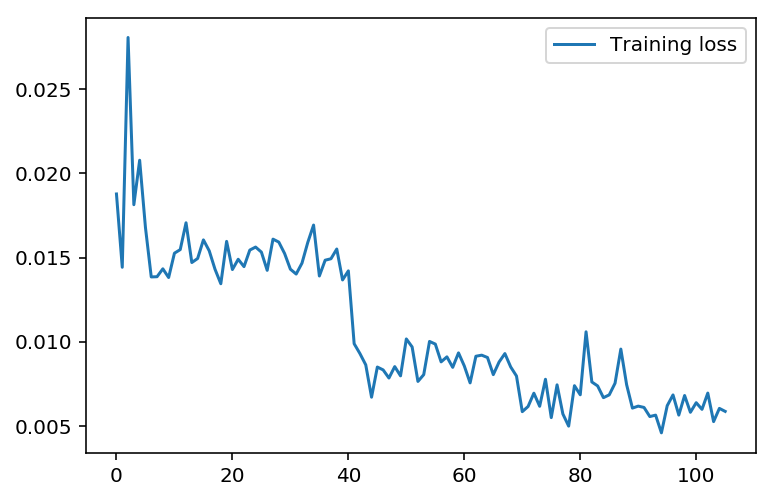

In [80]:
plt.plot(losses['train'],label='Training loss')
plt.legend()
_=plt.ylim()

## 显示测试Loss

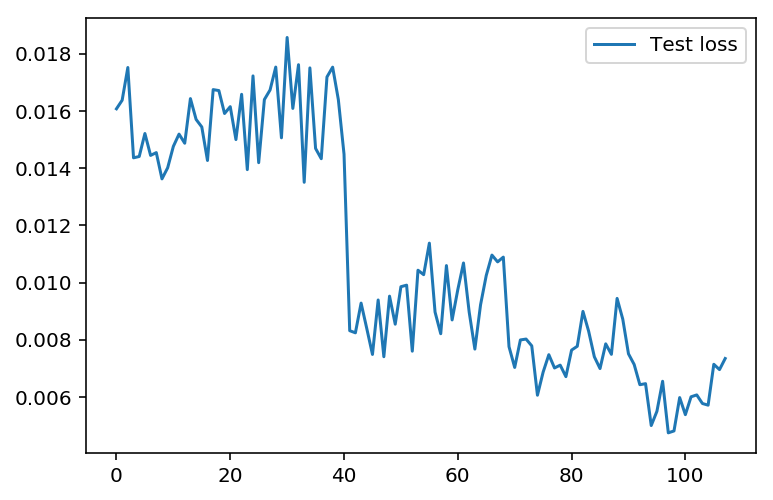

In [81]:
plt.plot(losses['test'],label='Test loss')
plt.legend()
_=plt.ylim()

## 显示训练CTR AUC

[0.5013686578369903, 0.5048305682319165, 0.5044356012035115, 0.5003785019698468, 0.469481169628826, 0.47968441355162206, 0.4708680873434951, 0.4706025951681436, 0.4717819514594521, 0.4746867748404814]


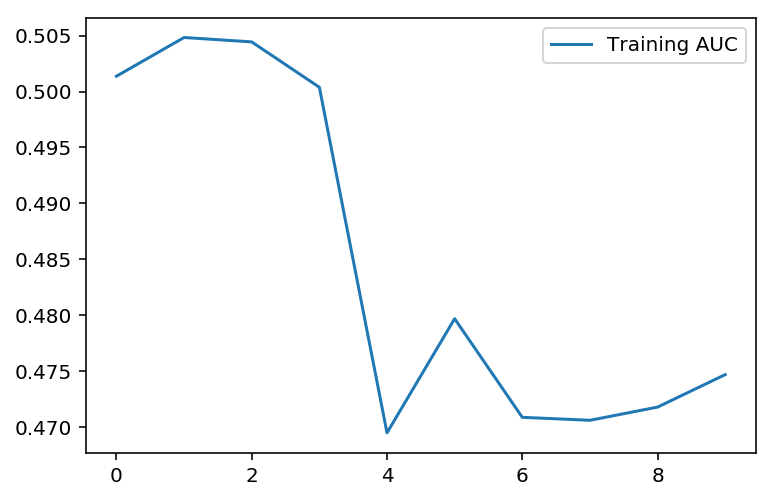

In [82]:
plt.plot(ctr_auc_stat['train'],label='Training AUC')
plt.legend()
_=plt.ylim()
print(ctr_auc_stat['train'])


## 显示测试CTR AUC

[0.4974488416635767, 0.4886095465175052, 0.4920437423744006, 0.49490961941200357, 0.48112440156417147, 0.47392515410712377, 0.4808059061049573, 0.46545896524771474, 0.477984501462904, 0.46621698704620884]


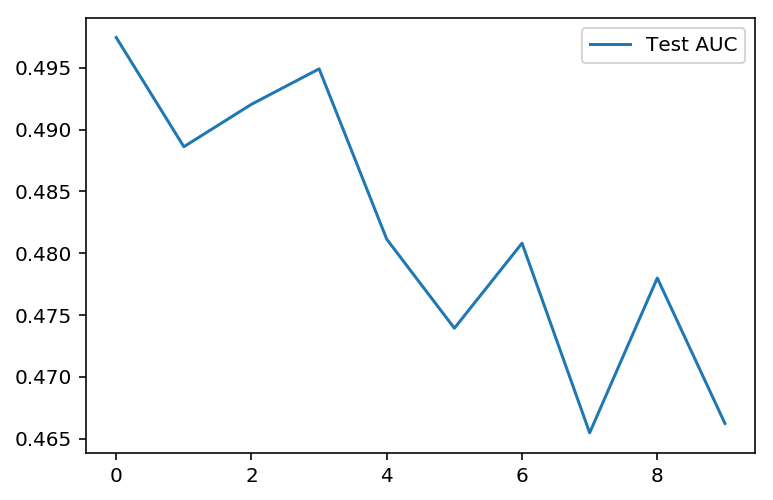

In [83]:
plt.plot(ctr_auc_stat['test'],label='Test AUC')
plt.legend()
_=plt.ylim()
print(ctr_auc_stat['test'])

## 显示训练CVR AUC

[0.5569950732533712, 0.6103119575600424, 0.6693720643205813, 0.6717053831808741, 0.6802406480594775, 0.693594013344624, 0.6950063716553079, 0.6844353922281938, 0.6833999205660073, 0.6986685027965913]


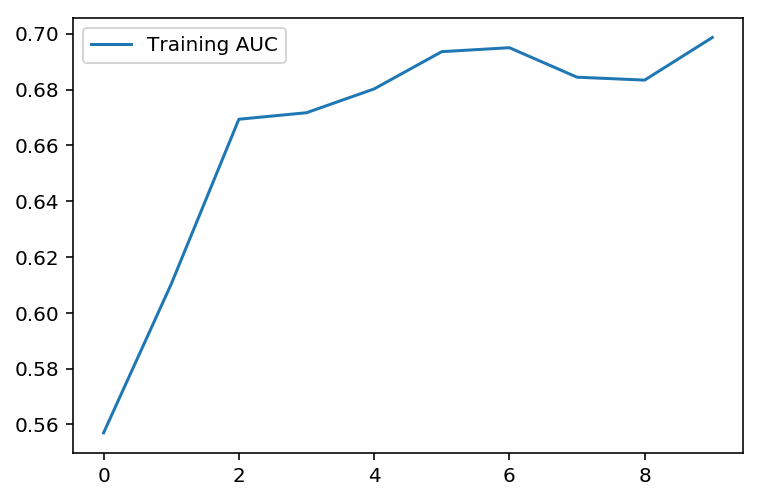

In [84]:
plt.plot(cvr_auc_stat['train'],label='Training AUC')
plt.legend()
_=plt.ylim()
print(cvr_auc_stat['train'])

## 显示测试CVR AUC

[0.6941540107850969, 0.6696407937319144, 0.6844658060636571, 0.6907175468004321, 0.6990091544294518, 0.6946628315487867, 0.6679798635191834, 0.6913489261604397, 0.7008041941775647, 0.6885052703561334]


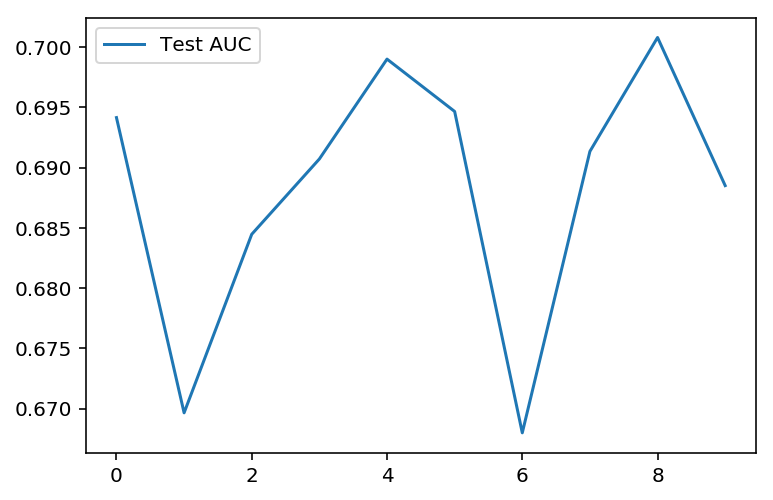

In [85]:
plt.plot(cvr_auc_stat['test'],label='Test AUC')
plt.legend()
_=plt.ylim()
print(cvr_auc_stat['test'])

## 显示训练CTCVR AUC

[0.5477562816764848, 0.5962214224644076, 0.6307467516040922, 0.6395859434138685, 0.6284466097097903, 0.6461840786215499, 0.6420818108669895, 0.638733640049311, 0.6344558426266713, 0.6565012324425442]


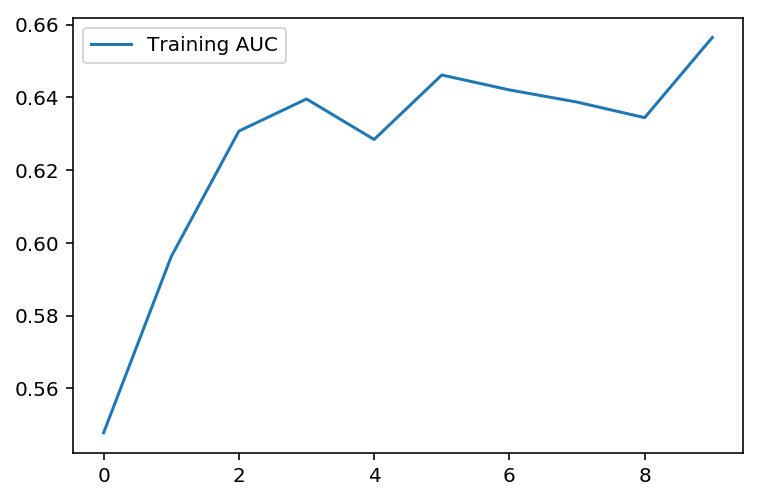

In [86]:
plt.plot(ctcvr_auc_stat['train'], label='Training AUC')
plt.legend()
_ = plt.ylim()
print(ctcvr_auc_stat['train'])

## 显示测试CTCVR AUC

[0.6508808696639261, 0.6248770592796162, 0.6374705790415478, 0.6446179828516982, 0.6510557714630398, 0.640145192003289, 0.6185436953830225, 0.6336150524464316, 0.6572425848403005, 0.6417586831273505]


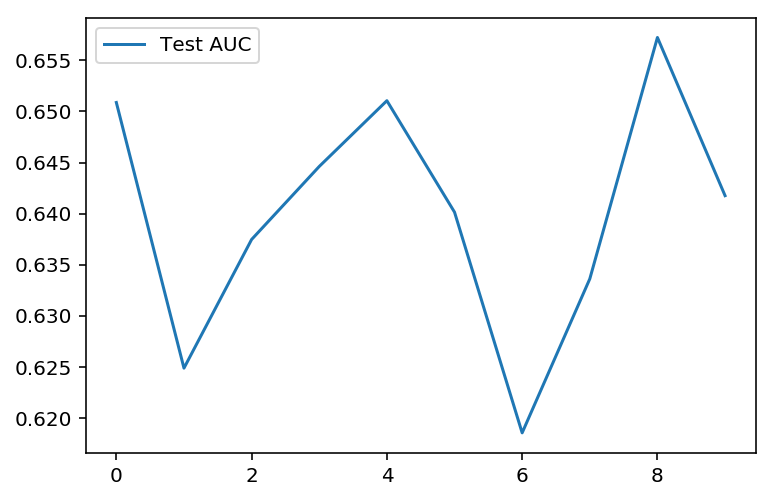

In [87]:
plt.plot(ctcvr_auc_stat['test'], label='Test AUC')
plt.legend()
_ = plt.ylim()
print(ctcvr_auc_stat['test'])

# 总结

ESMM模型利用用户行为序列数据在完整样本空间建模，避免了传统CVR模型经常遭遇的样本选择偏差和训练数据稀疏的问题，取得了显著的效果。另一方面，ESMM模型首次提出了利用学习CTR和CTCVR的辅助任务迂回学习CVR的思路。ESMM模型中的BASE子网络可以替换为任意的学习模型，因此ESMM的框架可以非常容易地和其他学习模型集成，从而吸收其他学习模型的优势，进一步提升学习效果，想象空间巨大。